# Forecasting of Retail Sales:

One our cousins in the spanish country have a grocery stores company which works in some villages in La Mancha. He have heard in the news something about the Machine Learning and its posibilities. Since he knows that we work as Data Scientist he has porpuse us to see if we can make a prediction in one of their products and we have accepted the offer. 

Our idea is to apply a couple of ML models and chechk if we can give him a good prediction of the sales of one of his products.

In [60]:
import pandas as pd # General imports
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


from sklearn.svm import SVR # Explicit imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

# from model_evaluation import calculoEvaluacionModelo # Fail in the import, does not recognize numpy.

fig_size = (29, 12) # Macrovariables
norma = False

In [76]:
# The function we have defined in the model_evaluation file:

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    for day in range(771,829): # We will maka the prediciton over the last two months.
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Unidades'], axis=1), val.drop(['Unidades'], axis=1)
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Unidades'].values, val['Unidades'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted= xPredicted + [day]
        yPredicted= yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = rmsle(yts, p) 
        print('Month %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sales predicted': yPredicted,
         'Actual Sales': ySpotted
        },index=xPredicted)

    prediction.plot(figsize = fig_size, 
        color = {'Sales predicted':'purple', 'Actual Sales':'salmon'},
        grid = True,
        title = 'Prediction in the sales of iberian ham')

We will make the prediction in the sale from the day

In [62]:
df = pd.read_csv('Dataframe_Retail.csv', parse_dates=['Fecha'])

In [63]:
df.info() # No null values int he data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fecha       10950 non-null  datetime64[ns]
 1   Referencia  10950 non-null  object        
 2   Unidades    10950 non-null  float64       
 3   Ventas      10950 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 342.3+ KB


## Data Analysis

What we can find in the dataframe is the sells of the each product each day and the money earned by the sale.

In [64]:
df['Referencia'].unique(), df['Referencia'].unique().shape

(array(['Cerveza tercio', 'Baguetes 2 unidades',
        'Aceite de oliva virgen extra 5 l', 'Bolsa naranjas 2Kg.',
        'Mandarina', 'Melo  OR', 'Jamón reserva', 'Naranja en cajas',
        'Pack de plátanos', 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)',
        'Tomate jugoso al peso', 'Filetes de salmón', 'Sepia',
        'Fresa premium 500gr'], dtype=object),
 (14,))

* We have fourteen different products that the grocery store have in sales, so we will choose one in order to make the prediction. As good spaniards we choose iberian jam (_"Jamón reserva"_). As we can see this parameter is a float64, so the ham can be sold not for units (kg for the ham) but also fractions of the units.

In [65]:
df = df.loc[df['Referencia'] == 'Jamón reserva'].\
    drop('Referencia', axis = 1).\
    set_index('Fecha')

In [66]:
df.iloc[771]

Unidades      48.760000
Ventas      1016.140008
Name: 2019-03-19 00:00:00, dtype: float64

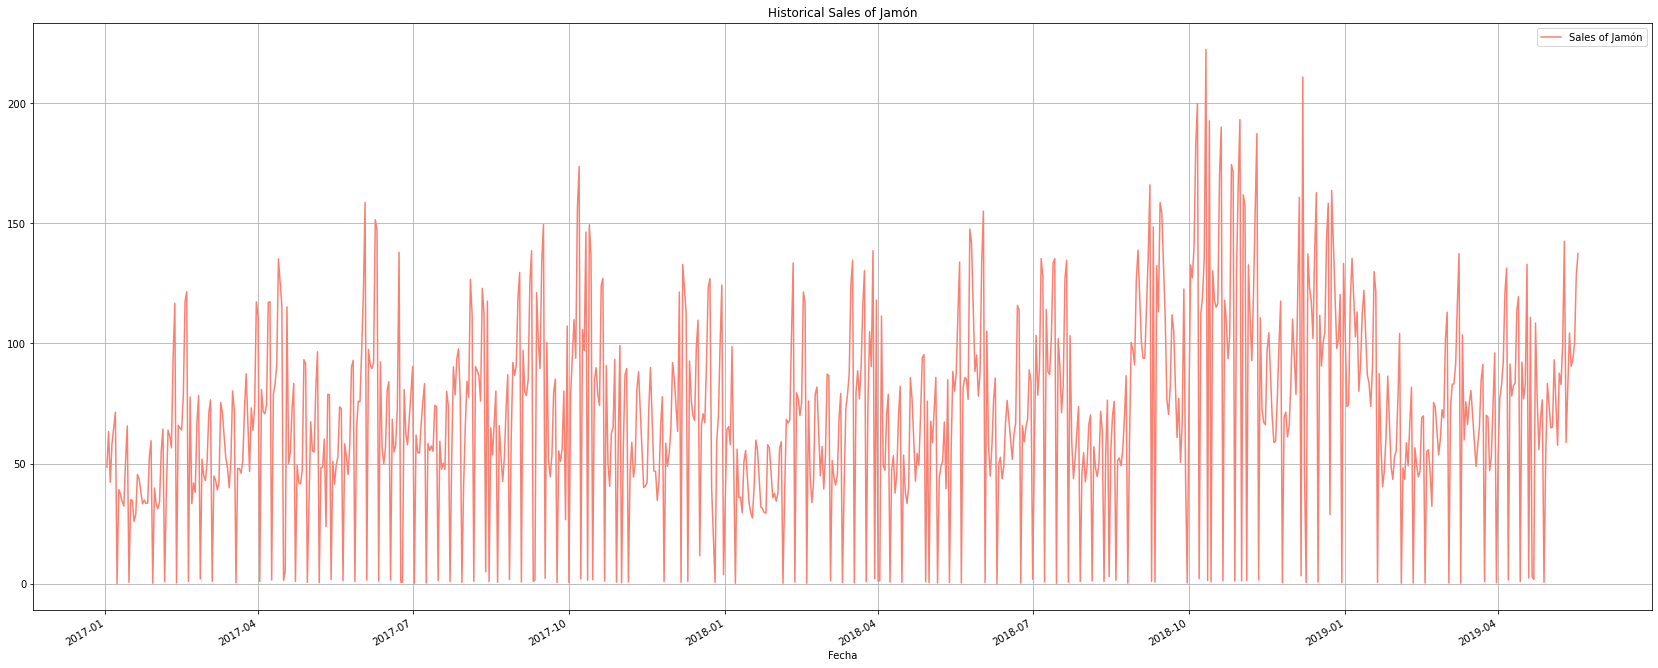

In [67]:
df['Unidades'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Historical Sales of Jamón');

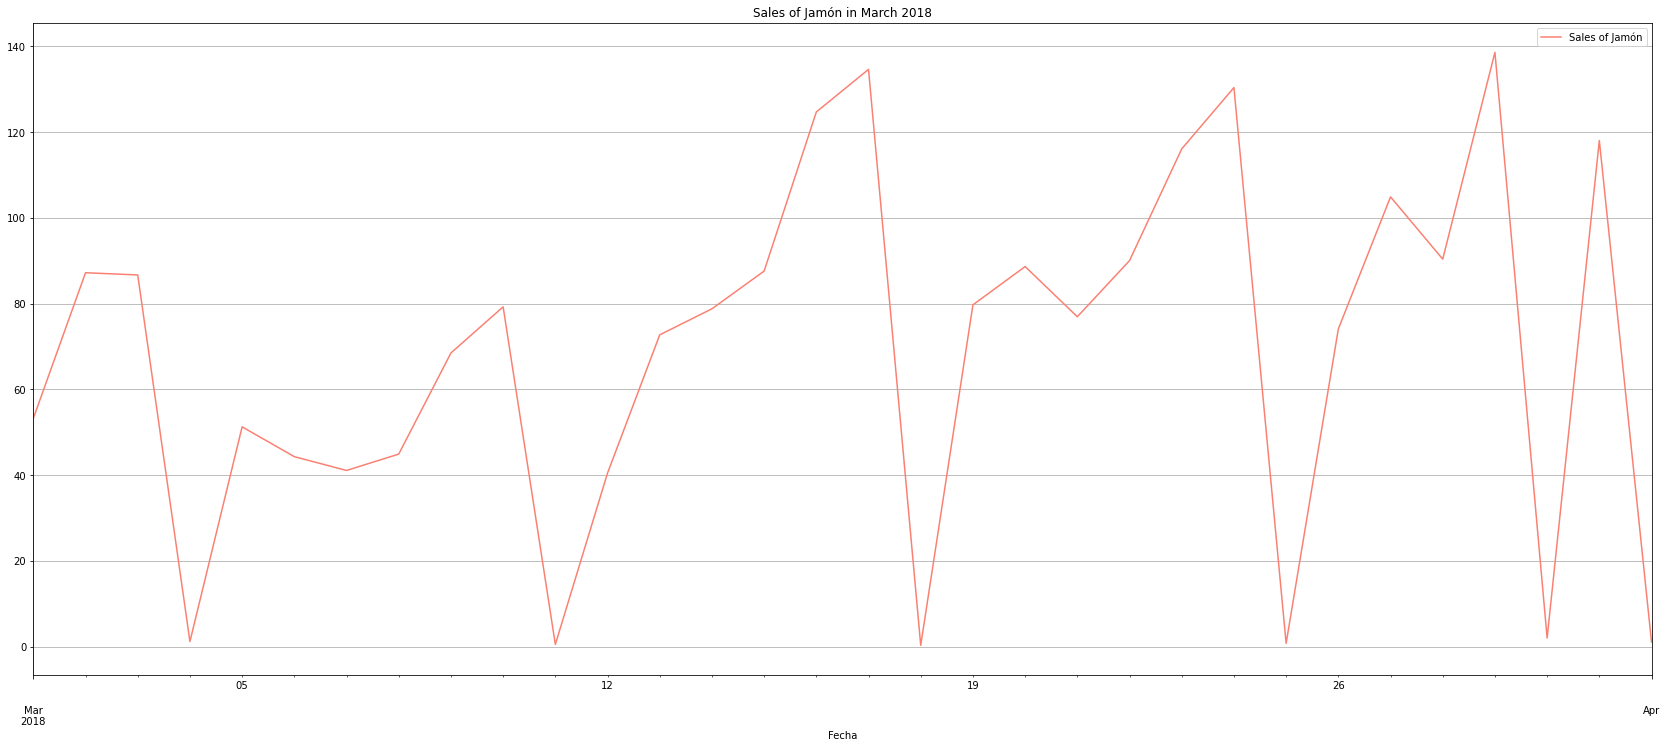

In [68]:
df['Unidades']['2018-03-01':'2018-04-01'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Sales of Jamón in March 2018');

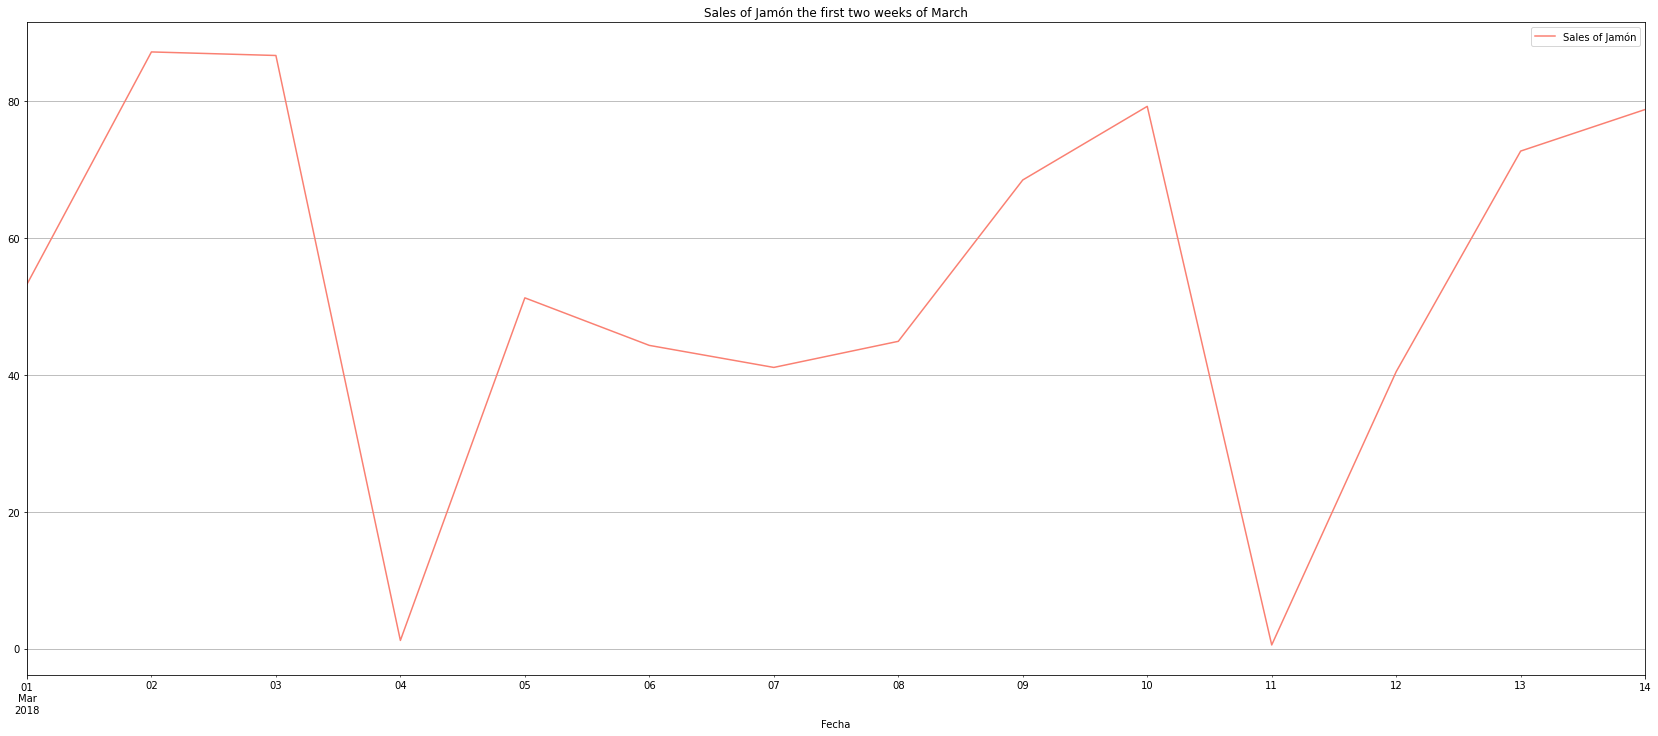

In [69]:
df['Unidades']['2018-03-01':'2018-03-14'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Sales of Jamón the first two weeks of March'); # We can see how we have some stationality at week level. March 4th and March 11th were both Sunday.

## Featuring Engineer:

We now will create artificial parameters in the data in order to make it more clear to the model. In this case we will take in account the day of the week of the sale by one-hot-enconding techniques and by shifting the sales we will also add information of the units sold last week.

In [70]:
df.reset_index(drop = False, inplace = True) # In order to train the model we can't have the date as the index, so we must use integer equally spaced, as the days are in this dataset.
df['OffsetDays'] = df.index

df['day of the week']  = df['Fecha'].dt.dayofweek
df['day of the week'] = df['day of the week'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'})
df = pd.concat([df, pd.get_dummies(df['day of the week'])], axis = 1).\
    drop(['day of the week', 'Fecha', 'Ventas'], axis = 1)

df['Shift_1'] = df['Unidades'].shift(1) # The sales of the day before can alsa be used as
df['Shift_2'] = df['Unidades'].shift(2)
df['Shift_3'] = df['Unidades'].shift(3)
df['Shift_4'] = df['Unidades'].shift(4)
df['Shift_5'] = df['Unidades'].shift(5)
df['Shift_6'] = df['Unidades'].shift(6)
df['Shift_7'] = df['Unidades'].shift(7)

df = df[7:]


## Random Forest:

In order to have a nice performance of the model we will modifiy the default hyperparameters, we will take 80 stimators (or decision trees) instead of the 100 stimators expected since we obtain similar performence in the half time of computation:

Month 771 - Error 0.37457
Month 772 - Error 0.14266
Month 773 - Error 0.06554
Month 774 - Error 0.02470
Month 775 - Error 0.00392
Month 776 - Error 0.38380
Month 777 - Error 0.19340
Month 778 - Error 0.03041
Month 779 - Error 0.40739
Month 780 - Error 0.09490
Month 781 - Error 0.03655
Month 782 - Error 0.15846
Month 783 - Error 0.20775
Month 784 - Error 0.14015
Month 785 - Error 0.23247
Month 786 - Error 0.50828
Month 787 - Error 0.02780
Month 788 - Error 0.08208
Month 789 - Error 0.04558
Month 790 - Error 1.03408
Month 791 - Error 0.26175
Month 792 - Error 0.01369
Month 793 - Error 0.03386
Month 794 - Error 0.06069
Month 795 - Error 0.06969
Month 796 - Error 0.00594
Month 797 - Error 0.46132
Month 798 - Error 0.23216
Month 799 - Error 0.00738
Month 800 - Error 0.06763
Month 801 - Error 0.44707
Month 802 - Error 3.58599
Month 803 - Error 0.33235
Month 804 - Error 1.02820
Month 805 - Error 3.01173
Month 806 - Error 0.34895
Month 807 - Error 0.08086
Month 808 - Error 0.48577
Month 809 - 

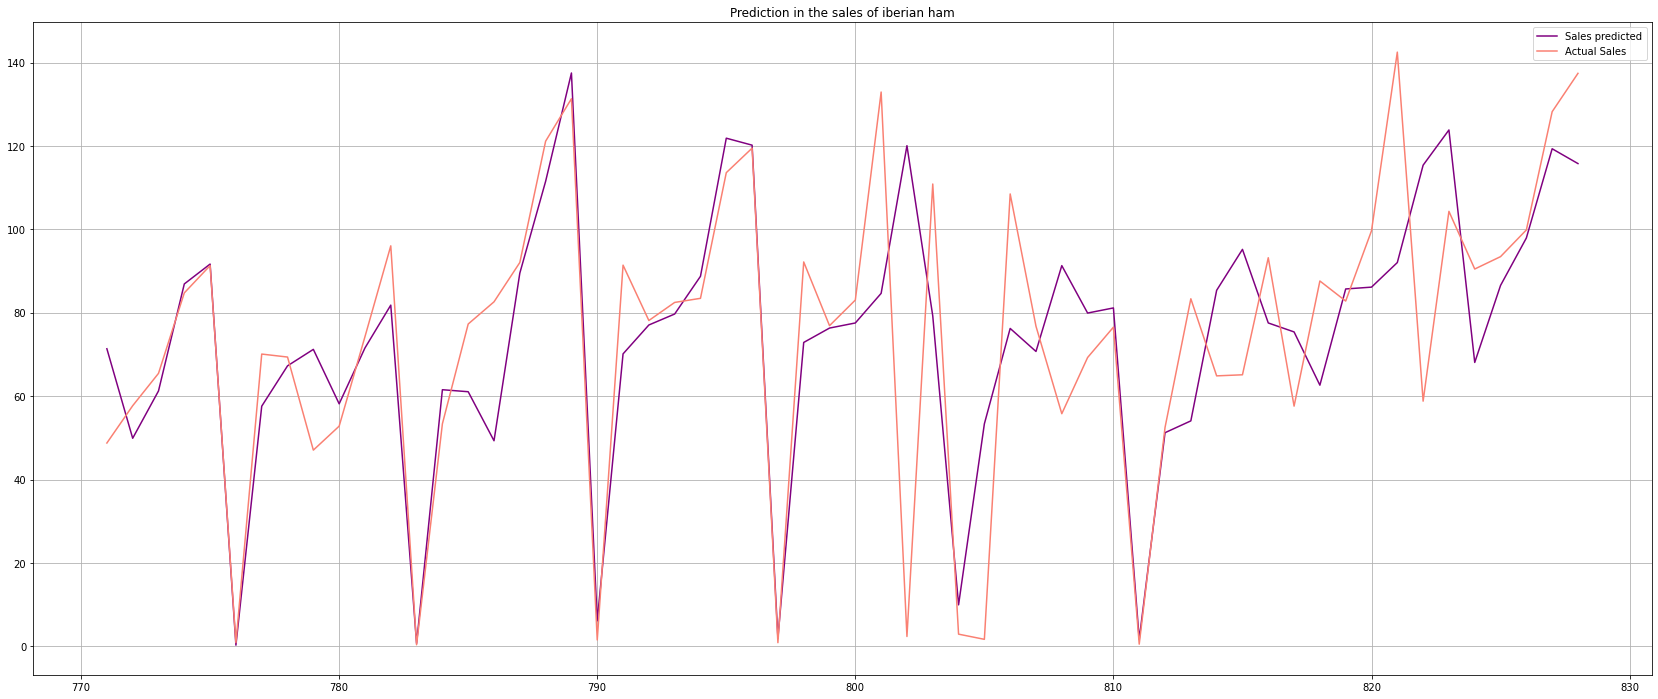

In [79]:
calculoEvaluacionModelo(RandomForestRegressor(n_estimators = 40, random_state = 132), df, norma)

## Support Vector Machines (SVM):

In this case we will apply the Support Vector Machine (Regressor), which certainly have a lower performance than the Random Forest model, however, it also takes a considerable less amount of time to give us a good result. In this case we will play with the hyperparameter _C_ which is the regualation parameter of the support vector machine.

Month 771 - Error 0.33634
Month 772 - Error 0.08046
Month 773 - Error 0.00127
Month 774 - Error 0.10306
Month 775 - Error 0.12281
Month 776 - Error 3.18886
Month 777 - Error 0.08249
Month 778 - Error 0.10993
Month 779 - Error 0.27810
Month 780 - Error 0.20469
Month 781 - Error 0.03262
Month 782 - Error 0.17232
Month 783 - Error 3.31501
Month 784 - Error 0.18710
Month 785 - Error 0.21749
Month 786 - Error 0.30341
Month 787 - Error 0.33504
Month 788 - Error 0.41095
Month 789 - Error 0.39807
Month 790 - Error 2.84692
Month 791 - Error 0.18902
Month 792 - Error 0.06551
Month 793 - Error 0.14270
Month 794 - Error 0.10824
Month 795 - Error 0.28354
Month 796 - Error 0.26626
Month 797 - Error 3.13483
Month 798 - Error 0.17552
Month 799 - Error 0.05171
Month 800 - Error 0.14976
Month 801 - Error 0.56961
Month 802 - Error 3.25841
Month 803 - Error 0.30249
Month 804 - Error 2.60429
Month 805 - Error 3.27885
Month 806 - Error 0.46640
Month 807 - Error 0.11213
Month 808 - Error 0.22831
Month 809 - 

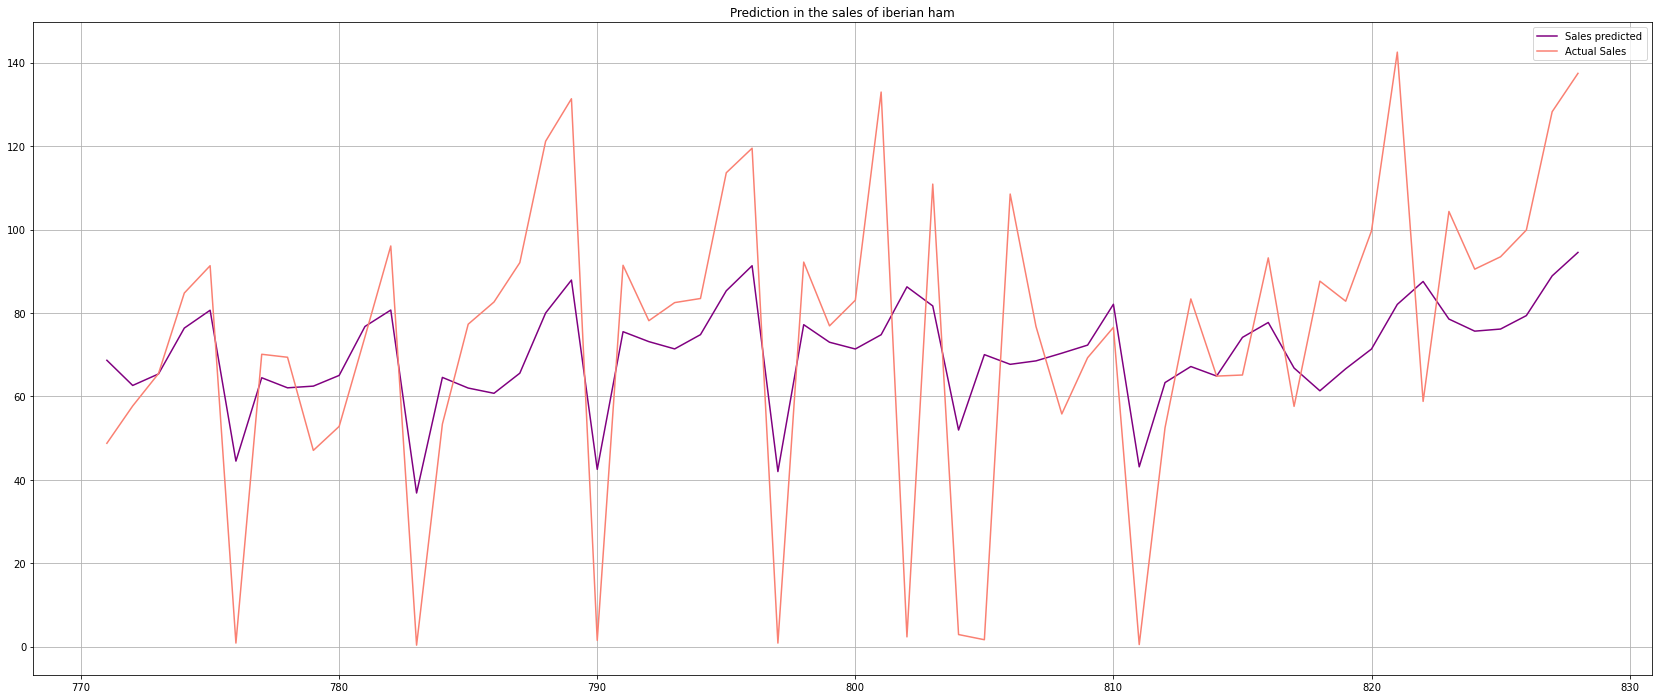

In [77]:
calculoEvaluacionModelo(SVR(C = 0.77), df, True)